In [1]:
from pathlib import Path
import os
import sys
import tensorflow as tf
import warnings
import numpy as np
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.data_check import is_downloaded, info
from genomic_benchmarks.models.tf import vectorize_layer
from genomic_benchmarks.models.tf import get_basic_cnn_model_v0 as get_model
import matplotlib.pyplot as plt
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from functools import partial
# from qiskit import Aer
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler
from qiskit_machine_learning.circuit.library import QNNCircuit
import json
import time
import warnings

warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.decomposition import PCA
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap
import datetime
from tqdm import tqdm


c:\Users\navne\anaconda3\envs\QML\Lib\site-packages\genomic_benchmarks\utils\datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
c:\Users\navne\anaconda3\envs\QML\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\navne\anaconda3\envs\QML\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or 

In [2]:

algorithm_globals.random_seed = 42



In [3]:
# Load the preprocessed data
train_sequences = np.load('train_sequences.npy')
# print('train_sequences',train_sequences[:2])
train_labels = np.load('train_labels.npy')
# print('train_labels',train_labels[:2])
test_sequences = np.load('test_sequences.npy')
# print('test_sequences',test_sequences[:2])
test_labels = np.load('test_labels.npy')
# print('test_labels',test_labels[:2])

print("Data loaded successfully")

Data loaded successfully


In [4]:
n_components=4
pca = PCA(n_components)  # for example, reduce to n dimensions
train_sequences_pca = pca.fit_transform(train_sequences)
test_sequences_pca = pca.fit_transform(test_sequences)
print("Train Sequences Shape after PCA with", n_components, "components:", train_sequences_pca.shape)
print("Test Sequences Shape after PCA with", n_components, "components:", test_sequences_pca.shape)

Train Sequences Shape after PCA with 4 components: (75000, 4)
Test Sequences Shape after PCA with 4 components: (25000, 4)


In [5]:
# Define the feature dimension or number of qubits
feature_dim = len(train_sequences_pca[0])

print("Feature dimension and number of qubits:", feature_dim)

Feature dimension and number of qubits: 4


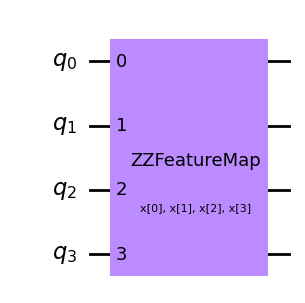

In [6]:
prep = ZZFeatureMap(feature_dim, reps=1)
prep.draw('mpl')

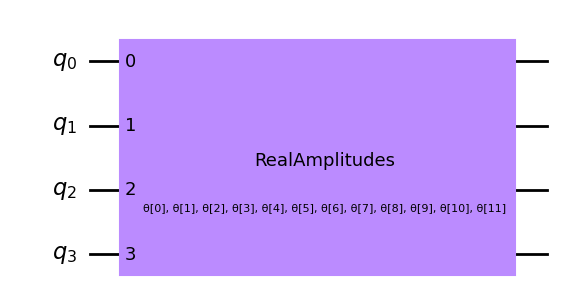

In [7]:
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=2)
ansatz.draw('mpl')

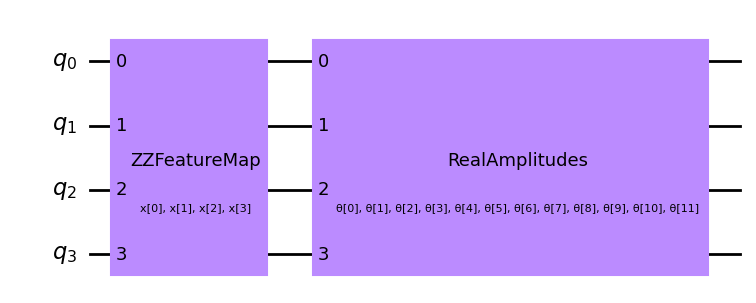

In [8]:
qc= QNNCircuit(num_qubits=feature_dim ,ansatz = ansatz, feature_map=prep)
qc.draw('mpl')

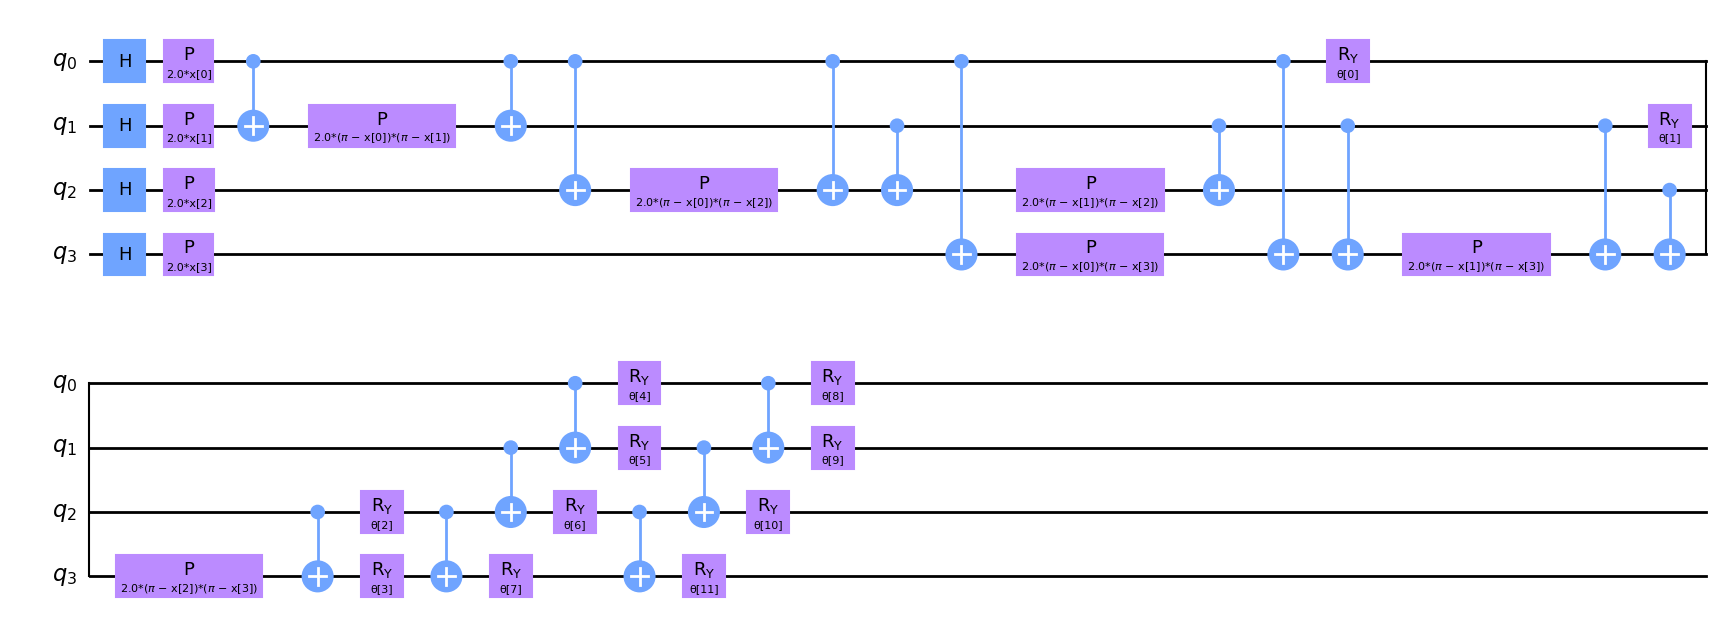

In [9]:
qc.decompose().draw('mpl')

In [10]:

def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2


In [11]:
sampler_qnn = SamplerQNN(
    circuit = qc,
    interpret=parity,
    output_shape=output_shape,
    input_gradients= True
)

In [12]:
objective_func_vals=[]

def callback_graph(weights, obj_func_eval):
    # clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    clear_output(wait=True)


itr = 0
def training_callback(weights, obj_func_eval):
        global itr
        itr += 1
        # print(f"{itr} {obj_func_eval}", end=' | ')
        
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=50), callback=callback_graph
)

In [13]:
num_epochs = 10
batch_size = 512
# Create a progress bar
print("Dataset size:", len(train_sequences_pca))
print("Number of epochs:", num_epochs)
print("Batch size:", batch_size)
print("Number of batches:", len(train_sequences_pca) // batch_size)

Dataset size: 75000
Number of epochs: 10
Batch size: 512
Number of batches: 146


In [14]:
# import time

# # Initialize variables
# num_epochs = 5
# total_time = 0


# # Training loop
# for epoch in range(num_epochs):
#     start_time = time.time()
    
#     # Perform training for current epoch
    
#     end_time = time.time()
#     epoch_time = end_time - start_time
#     total_time += epoch_time
    
#     print(f"Epoch {epoch+1} - Time taken: {epoch_time:.2f} seconds")

# print(f"Total training time: {total_time:.2f} seconds")


In [15]:
# import time

# def my_function():
#     # Code to be measured

# start_time = time.time()
# my_function()
# end_time = time.time()

# execution_time = end_time - start_time
# print("Execution time:", execution_time, "seconds")


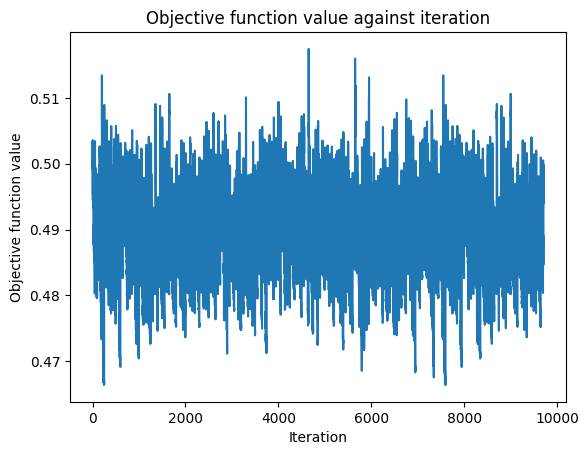

In [16]:
import time

# Initialize variables
# num_epochs = 5
total_time = 0

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    
    # 
    progress_bar = tqdm(total=num_epochs, desc="Training")
    for epoch in range(num_epochs):# Perform training for each batch
        for i in range(0, len(train_sequences_pca), batch_size):
            batch_sequences = train_sequences_pca[i:i+batch_size]
            batch_labels = train_labels[i:i+batch_size]
        # Train the classifier on the batch
            sampler_classifier.fit(batch_sequences, batch_labels)
            print(f"Epoch {epoch + 1} - Batch {i // batch_size + 1} completed")
    # Update the progress bar
        progress_bar.update(1)

# Close the progress bar
    progress_bar.close()
    
    end_time = time.time()
    epoch_time = end_time - start_time
    total_time += epoch_time
    
    print(f"Epoch {epoch+1} - Time taken: {epoch_time:.2f} seconds")

print(f"Total training time: {total_time:.2f} seconds")

In [ ]:
# # Train the classifier

# progress_bar = tqdm(total=num_epochs, desc="Training")
# for epoch in range(num_epochs):
#     # Perform training for each batch
#     for i in range(0, len(train_sequences_pca), batch_size):
#         batch_sequences = train_sequences_pca[i:i+batch_size]
#         batch_labels = train_labels[i:i+batch_size]
#         # Train the classifier on the batch
#         sampler_classifier.fit(batch_sequences, batch_labels)
#         print(f"Epoch {epoch + 1} - Batch {i // batch_size + 1} completed")
#     # Update the progress bar
#     progress_bar.update(1)

# # Close the progress bar
# progress_bar.close()

In [ ]:
current_datetime = datetime.datetime.now()

# Create a log entry with the current date, time, and score
log_entry = f"{current_datetime}: Score - {sampler_classifier.score(test_sequences_pca,test_labels)}"
print(log_entry)
# Specify the path to the log file
log_file_path = "/d:/PhD/QML_genomic/QML_genom/log.txt"

# Check if the log file already exists
if os.path.exists(log_file_path):
    # If the log file exists, append the log entry to a new line
    with open(log_file_path, "a") as log_file:
        log_file.write(f"\n{log_entry}")
else:
    # If the log file does not exist, create a new log file and write the log entry
    with open(log_file_path, "w") as log_file:
        log_file.write(log_entry)